In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import data_processing.load_sqlite as load_sql

In [23]:
df_all = load_sql.fetch_movies(add_one_hot_genres=True)
df_all.head()

,movie_id,title,release_date,budget,revenue,runtime,vote_average,vote_count,popularity,genre_Adventure,...,genre_Thriller,genre_Crime,genre_Documentary,genre_Science Fiction,genre_Mystery,genre_Music,genre_Romance,genre_Family,genre_War,genre_TV Movie
0,2,Ariel,1988-10-21,0,0,73,7.113,341.0,10.293,0,...,0,1,0,0,0,0,1,0,0,0
1,3,Shadows in Paradise,1986-10-17,0,0,74,7.300,404.0,6.501,0,...,0,0,0,0,0,0,1,0,0,0
2,5,Four Rooms,1995-12-09,4000000,4257354,98,5.858,2674.0,20.027,0,...,0,1,0,0,0,0,0,0,0,0
3,6,Judgment Night,1993-10-15,21000000,12136938,109,6.500,345.0,13.275,0,...,1,1,0,0,0,0,0,0,0,0
4,8,Life in Loops (A Megacities RMX),2006-01-01,42000,0,80,7.400,29.0,0.450,0,...,0,0,1,0,0,0,0,0,0,0


In [24]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 888663 entries, 0 to 888662
Data columns (total 28 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   movie_id               888663 non-null  int64         
 1   title                  888663 non-null  object        
 2   release_date           888582 non-null  datetime64[ns]
 3   budget                 888663 non-null  int64         
 4   revenue                888663 non-null  int64         
 5   runtime                888663 non-null  int64         
 6   vote_average           888663 non-null  float64       
 7   vote_count             888663 non-null  float64       
 8   popularity             888663 non-null  float64       
 9   genre_Adventure        888663 non-null  int64         
 10  genre_Fantasy          888663 non-null  int64         
 11  genre_Animation        888663 non-null  int64         
 12  genre_Drama            888663 non-null  int6

In [27]:
# Set the color palette
sns.set_theme(style="whitegrid")
custom_palette = sns.color_palette("viridis")

In [28]:
df_clean = df_all.dropna(subset=["runtime"])  # Drop missing runtimes
df_clean = df_clean[df_clean["runtime"] >= 60]  # Remove "shorts" which we define as movies shorter than an hour

In [29]:
# Compute the interquartile range:
Q1 = df_clean["runtime"].quantile(0.25)
Q3 = df_clean["runtime"].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds (1.5 * IQR rule)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the dataframe
df_clean = df_clean[(df_clean["runtime"] >= lower_bound) & (df_clean["runtime"] <= upper_bound)]

print(f"Original dataset size: {len(df_all)}")
print(f"Cleaned dataset size: {len(df_clean)}")

Original dataset size: 888663
Cleaned dataset size: 348883


In [30]:
df_clean = df_clean[df_clean["release_date"].dt.year < 2026]

In [31]:
# Rename dataframe for convenience:
df = df_clean

In [32]:
df["release_year"] = df["release_date"].dt.year

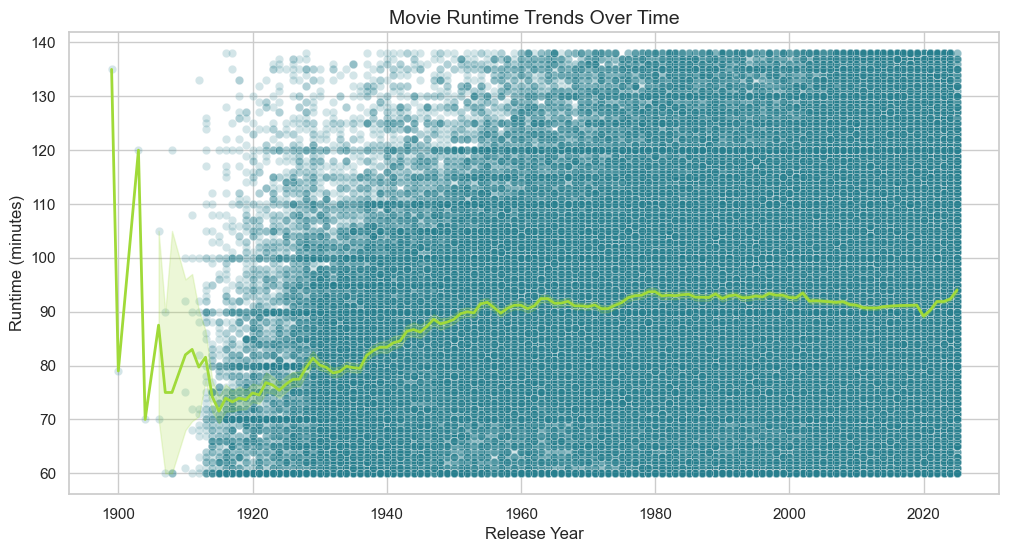

In [33]:
plt.figure(figsize=(12, 6))

# Scatter plot for individual data points
sns.scatterplot(data=df, x="release_year", y="runtime", alpha=0.2, color=custom_palette[2])

# Smoothed trend line
sns.lineplot(data=df, x="release_year", y="runtime", color=custom_palette[-1], linewidth=2, estimator='mean')

plt.title("Movie Runtime Trends Over Time", fontsize=14)
plt.xlabel("Release Year")
plt.ylabel("Runtime (minutes)")
plt.show()

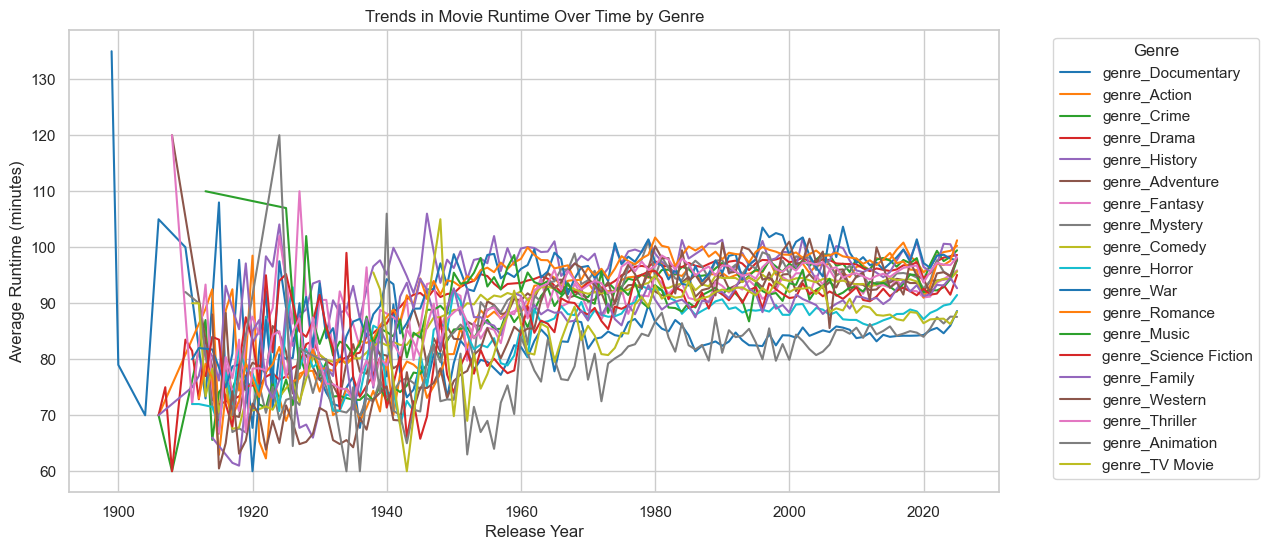

In [34]:
# Melt the one-hot encoded genres
genre_cols = [col for col in df.columns if col.startswith("genre_")]
df_genre = df.melt(id_vars=["release_year", "runtime"], value_vars=genre_cols, 
                         var_name="genre", value_name="is_genre")

# Filter only rows where the genre is present
df_genre = df_genre[df_genre["is_genre"] == 1]

# Compute average runtime per year per genre
genre_runtime_trends = df_genre.groupby(["release_year", "genre"])["runtime"].mean().reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.lineplot(data=genre_runtime_trends, x="release_year", y="runtime", hue="genre", palette="tab10")

plt.xlabel("Release Year")
plt.ylabel("Average Runtime (minutes)")
plt.title("Trends in Movie Runtime Over Time by Genre")
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()